<a href="https://colab.research.google.com/github/memo-math/Proyecto-Final-CienciadeDatos-CF/blob/main/XG_final_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación del modelo

In [1]:
#Empecemos cargando las librerías necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay

In [2]:
all_shots = pd.read_csv('shots_limpieza.csv')
all_shots.head()

,Unnamed: 0,period,minute,location,under_pressure,player_name,pattern_of_play,team,player_position,statsbomb_xg,technique,body_part,tipe,first_time,goal,location_x,location_y,distance,angle
0,0,1,1,"[100.6, 54.6]",0.0,Stine Larsen,From Keeper,Aston Villa,Left Center Forward,0.037459,Normal,Left Foot,Open Play,0,0,100.6,54.6,24.280033,0.264280
1,1,1,5,"[109.4, 43.0]",0.0,Vivianne Miedema,From Corner,Arsenal WFC,Left Wing,0.026655,Normal,Head,Open Play,0,0,109.4,43.0,11.016351,0.677697
2,2,1,6,"[95.6, 38.9]",0.0,Jill Roord,From Throw In,Arsenal WFC,Left Center Midfield,0.034884,Normal,Right Foot,Open Play,0,0,95.6,38.9,24.424782,0.324347
3,3,1,10,"[95.6, 44.6]",0.0,Bethany Mead,From Throw In,Arsenal WFC,Center Forward,0.020819,Normal,Right Foot,Open Play,0,0,95.6,44.6,24.829821,0.314279
4,4,1,14,"[111.0, 33.7]",0.0,Leah Williamson,From Corner,Arsenal WFC,Right Center Back,0.112665,Half Volley,Left Foot,Open Play,1,0,111.0,33.7,10.985900,0.602454


Una vez que tenemos cargados los datos seleccionaremos las variables que formarán parte de nuestro modelo

In [3]:
df_modelo = all_shots[['minute', 'pattern_of_play', 'technique', 'body_part', 'tipe', 'first_time', 'goal', 'distance', 'angle', 'under_pressure']]

Sabemos que nuestras variables categóricas no pueden ser interpretadas así como están, por lo que aplicaremos one-hot encoding.

In [4]:
#Empezamos con la columna tipe
df_modelo['tipe'].value_counts()

Open Play    8985
Free Kick     285
Penalty        89
Corner          3
Name: tipe, dtype: int64

In [ ]:
enc_tipe = OneHotEncoder(handle_unknown='ignore')
enc_tipe_df = pd.DataFrame(enc_tipe.fit_transform(df_modelo[['tipe']]).toarray())
enc_tipe_df.rename(columns={0: 'tipe0', 1: 'tipe1', 2:'tipe2', 3:'tipe3', 4:'tipe4'}, inplace=True)
enc_tipe_df.head()

In [6]:
#Ahora unamos el dataframe enc_tipe_df con el df_modelo
df_modelo = pd.concat([df_modelo, enc_tipe_df], axis=1)

In [7]:
#Continuemos con la columna body_part
df_modelo['tipe'].value_counts()

Open Play    8985
Free Kick     285
Penalty        89
Corner          3
Name: tipe, dtype: int64

In [ ]:
enc_body_part = OneHotEncoder(handle_unknown='ignore')
enc_body_part_df = pd.DataFrame(enc_body_part.fit_transform(df_modelo[['body_part']]).toarray()) 
enc_body_part_df.rename(columns={0: 'bodypart0', 1: 'bodypart1', 2:'bodypart2', 3:'bodypart3'}, inplace=True)
enc_body_part_df.head()

In [10]:
#Unamos los dataframes
df_modelo=pd.concat([df_modelo, enc_body_part_df], axis=1)

In [11]:
#Ahora transformemos la variable pattern_of_play
df_modelo['pattern_of_play'].value_counts()

Regular Play      3332
From Throw In     1884
From Corner       1593
From Free Kick    1409
From Counter       506
From Goal Kick     317
Other              123
From Keeper        102
From Kick Off       96
Name: pattern_of_play, dtype: int64

In [ ]:
enc_jugada = OneHotEncoder(handle_unknown='ignore')
enc_jugada_df = pd.DataFrame(enc_jugada.fit_transform(df_modelo[['pattern_of_play']]).toarray()) 
enc_jugada_df.rename(columns={0: 'play0', 1: 'play1', 2:'play2', 3:'play3', 4:'play4', 5:'play5', 6:'play6', 7:'play7', 8:'play8'}, inplace=True)
enc_jugada_df.head()

In [13]:
#Unamos los datasets
df_modelo=pd.concat([df_modelo, enc_jugada_df], axis=1)

In [14]:
df_modelo['technique'].value_counts()

Normal           7735
Half Volley       936
Volley            534
Lob                76
Backheel           40
Diving Header      22
Overhead Kick      19
Name: technique, dtype: int64

In [ ]:
#sigamos con la columna technique
enc_technique = OneHotEncoder(handle_unknown='ignore')
enc_technique_df = pd.DataFrame(enc_technique.fit_transform(df_modelo[['technique']]).toarray()) #cambiarle el nombre a este df muy mal nombrado
enc_technique_df.rename(columns={0: 'technique0', 1: 'technique1', 2:'technique2', 3:'technique3', 4:'technique4', 5:'technique5', 6:'technique6'}, inplace=True)
enc_technique_df.head()

In [16]:
df_modelo=pd.concat([df_modelo,enc_technique_df], axis=1)

Procedemos a deshacernos de las variables categóricas a las cuales les acabamos de aplicar one-hot encoding

In [17]:
df_modelo=df_modelo.drop(['pattern_of_play', 'technique', 'body_part', 'tipe'], axis=1)

Ahora debemos escalar nuestras variables continuas. Para las variables `distance` y `angle` usaremos `RobustScaler()` debido a que cuando vimos su distribución cuentan con outliers, mientras que para la columna `minute` usaremos el `MinMaxScaler()`

In [19]:
scaler_distance = RobustScaler()
scaler_distance.fit(df_modelo[['distance']])
df_modelo['distance']=scaler_distance.transform(df_modelo[['distance']])

scaler_angle = RobustScaler()
scaler_angle.fit(df_modelo[['angle']])
df_modelo['angle']=scaler_angle.transform(df_modelo[['angle']])

scaler_minute = MinMaxScaler()
scaler_minute.fit(df_modelo[['minute']])
df_modelo['minute']=scaler_minute.transform(df_modelo[['minute']])

Antes de separar nuestro dataset en train y test veamos si existen valores faltantes

In [20]:
df_modelo.isna().sum()

minute            0
first_time        0
goal              0
distance          0
angle             2
under_pressure    0
tipe0             0
tipe1             0
tipe2             0
tipe3             0
bodypart0         0
bodypart1         0
bodypart2         0
bodypart3         0
play0             0
play1             0
play2             0
play3             0
play4             0
play5             0
play6             0
play7             0
play8             0
technique0        0
technique1        0
technique2        0
technique3        0
technique4        0
technique5        0
technique6        0
dtype: int64

Como solo son dos valores podemos proceder a quitar estas observacionesd del dataset

In [21]:
df_modelo=df_modelo.dropna()

Dividamos el target del dataset, y luego separamos los datos de entrenamiento de los datos de prueba

In [22]:
Y = df_modelo['goal']
X = df_modelo.drop('goal', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

Comenzaremos por implementar la regresión logística

In [23]:
#definamos una grilla de los parámetros del modelo
lr_grid = {
    'max_iter': [200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],                                       
}
#implementemos un gridsearchcv
lrmodel_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_grid, verbose=1, cv=10)
lrmodel_grid.fit(x_train, y_train)
print(lrmodel_grid.best_estimator_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
LogisticRegression(max_iter=200, solver='newton-cg')


Una vez que ya tenemos nuestro modelo entrenado somos capaces de predecir la probabilidad con la que un tiro se convierte en gol. Por ejemplo, determinemos el xG de los tiros en `x_test`

In [24]:
lrmodel_grid.predict_proba(x_test)[:4]

array([[0.91730018, 0.08269982],
       [0.94904516, 0.05095484],
       [0.97705265, 0.02294735],
       [0.92093182, 0.07906818]])

El método `.predict_proba` regresa la probabilidad de que el tiro pertenezca, en este caso, a la clase 0 y a la clase 1, respectivamente. El orden de las clases lo podemos encontrar en `self.classes_`

Es momento de evaluar el desempeño de nuestro modelo, empezaremos obteniendo al matriz de confusión

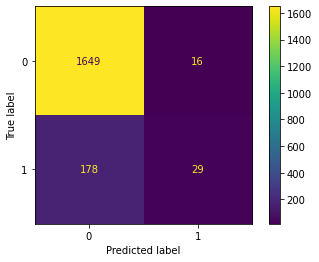

In [26]:
ConfusionMatrixDisplay.from_estimator(lrmodel_grid, x_test, y_test)

Como podemos ver nuestro modelo hace un buen trabajo prediciendo aquellos tiros que no terminan en gol. Sin embargo, lo hace mal cuando tiene que predecir la otra clase.

También podemos trazar la ROC-curve y sacar una métrica como el recall para seguir observando el desempeño de nuestro modelo

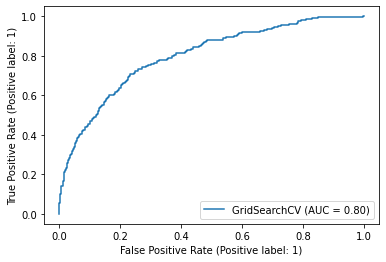

In [28]:
RocCurveDisplay.from_estimator(lrmodel_grid, x_test, y_test)

Una manera de ver la curva ROC es que entre más cercana este a la diagonal de 45° que pasa por $(0, 0)$ menos preciso es el modelo.

In [29]:
y_pred=lrmodel_grid.predict(x_test)
print("el recall score es  ", recall_score(y_test, y_pred))

el recall score es   0.14009661835748793


El recall score mide que tan bien el modelo predijo todas las posibles observaciones positivas.

[ref](https://saifmorahman.medium.com/interpreting-accuracy-precision-recall-and-f1-score-metrics-46bba7f00b2c)

Ahora podemos implementar un nuevo modelo de ML, en este caso usaremos el Random Forest Classifier

In [30]:
rf=RandomForestClassifier() 


#Definimos una grilla
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#buscamos los mejores parámetros con RandomizedSearchCV
rf_random = RandomizedSearchCV(rf, random_grid, n_iter =10, cv=3)
#entrenamos el modelo
rf_random.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

Ahora evaluemos el desempeño de este modelo con las métricas anteriores

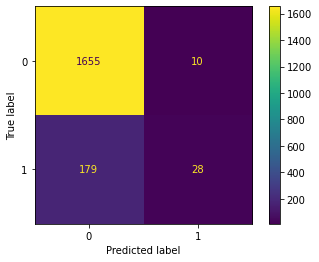

In [31]:
ConfusionMatrixDisplay.from_estimator(rf_random, x_test, y_test)

Podemos ver que este nuevo modelo no representa un cambio significativo con el modelo anterior respecto a predecir correctamente la clase 1 (goles)

Para terminar también podemos trazar la ROC curve y determinar el recall

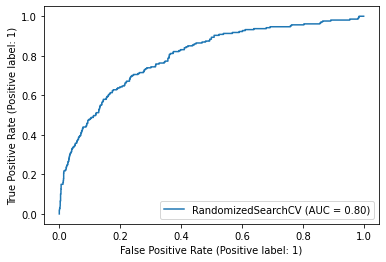

In [32]:
RocCurveDisplay.from_estimator(rf_random, x_test, y_test)

In [34]:
y_pred_rf = rf_random.predict(x_test)
print('el recall score es:  ', recall_score(y_test, y_pred_rf))

el recall score es:   0.13526570048309178


## Últimas consideraciones

* La inspiración para este proyecto salió del canal de youtube llamado **friends of tracking**
* El performance de nuestro modelo, a mí parecer, puede mejorar si quitamos algunas variables que parecen no ser tan importantes para predecir.
* Además de lo anterior, existen limitaciones del modelo xG. Se puede ver una discusión sobre el tema [aquí](https://www.youtube.com/watch?v=310_eW0hUqQ)
* Por último, existen muchas cuestiones que se pueden mejorar en este trabajo (por ejemplo, se podría crear una función para toda la carga de datos), en las cuales espero trabajar pronto.

:D  